In [1]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import math
import datetime
import statsmodels.api as sm
from rpy2.robjects.packages import importr
from rpy2.rinterface import RRuntimeError
from rpy2.rinterface import NARealType
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
import scipy as sp
from sklearn import linear_model
from yahoo_finance import Share
import pandas_datareader as web
from pandas.tseries.offsets import BDay
regress = linear_model.LinearRegression(fit_intercept=True)
failed_combination={}

r_forecast = importr("forecast")
stats = importr('stats')
tseries = importr('tseries')
pandas2ri.activate()
r_forecast_obj = importr("DemandForecasting")

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def linear_coeff(comb_df):
    
    X_train = comb_df[['index']]
    Y_train = comb_df[['Frequency']]
    regress.fit(X_train, Y_train)

    ###############Analysis and final output of trend######################

    if regress.coef_ > 1:
        trend_temp= 'Up-trend Demand'
    elif regress.coef_ < -1:
        trend_temp = 'Down-trend Demand'
    else:
        trend_temp= 'Constant Demand'

    trend_strength_temp = regress.coef_[0][0]

    return trend_temp, trend_strength_temp

In [7]:
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
Company_Name = "Tesla"
Company_Code = "TSLA"

tesla = web.DataReader(Company_Code, "yahoo", start, end)

In [8]:
typeof = "Close"
comb_df = tesla[[typeof]]
comb_df['Time_Line'] = comb_df.index
comb_df = comb_df.rename(columns={typeof: 'Frequency'})
comb_df = comb_df.reset_index(drop=True)
comb_df['index'] = comb_df.index
comb_df['Year'] = comb_df.Time_Line.dt.year
comb_df['month'] = comb_df.Time_Line.dt.month

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
data={}
trend_strength={}
trend={}

trend[Company_Name],trend_strength[Company_Name]=linear_coeff(comb_df)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [17]:
###############################################################################
r_skill_print_freq = pandas2ri.py2ri(comb_df)
Forecasting_horizon=6
r_prediction_period = ro.IntVector([Forecasting_horizon])


# try:
r_out = r_forecast_obj.hcl_decomposition_stl(r_skill_print_freq)
           
# except RRuntimeError as e:
#     Exceptional_skills.append(comb_str)


mat_stl = pandas2ri.ri2py(r_out.rx()[0])
df_stl = pd.DataFrame(mat_stl, columns=['Seasonal', 'Trend', 'Reminder'])
trend_decomp = np.array(df_stl.Trend)
seasonal_decomp = np.array(df_stl.Seasonal)[0:12]
                
data[Company_Name] = {'date': [datetime.datetime.strptime(temp100.strftime('%Y%m%d'),'%Y%m%d').strftime('%Y/%m/%d') for temp100 in comb_df.Time_Line],'frequency': np.array(comb_df.Frequency).tolist(),
                        'seasonal':  seasonal_decomp.tolist(),  \
                        'trend': trend_decomp.tolist(),\
                        'trend_strength': regress.coef_[0][0]\
                    }

In [19]:
data['Tesla'].keys()

dict_keys(['date', 'frequency', 'seasonal', 'trend', 'trend_strength'])

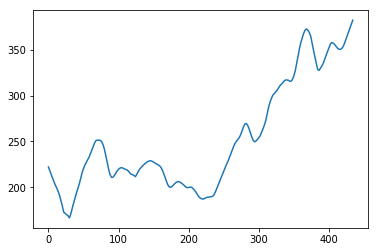

In [23]:
import matplotlib.pyplot as plt
plt.plot(data['Tesla']['trend'])
plt.show()

In [24]:
df_stl.Seasonal

0      0.156864
1     -1.815186
2     -0.567593
3     -0.436902
4      0.705294
5      1.250208
6      0.667933
7     -1.338168
8     -0.282235
9      0.671483
10     0.938558
11     0.049746
12     0.156864
13    -1.815186
14    -0.567593
15    -0.436902
16     0.705294
17     1.250208
18     0.667933
19    -1.338168
20    -0.282235
21     0.671483
22     0.938558
23     0.049746
24     0.156864
25    -1.815186
26    -0.567593
27    -0.436902
28     0.705294
29     1.250208
         ...   
405    0.671483
406    0.938558
407    0.049746
408    0.156864
409   -1.815186
410   -0.567593
411   -0.436902
412    0.705294
413    1.250208
414    0.667933
415   -1.338168
416   -0.282235
417    0.671483
418    0.938558
419    0.049746
420    0.156864
421   -1.815186
422   -0.567593
423   -0.436902
424    0.705294
425    1.250208
426    0.667933
427   -1.338168
428   -0.282235
429    0.671483
430    0.938558
431    0.049746
432    0.156864
433   -1.815186
434   -0.567593
Name: Seasonal, Length: 

In [ ]:
output ={'source':data}
with open(output_file,'wb') as fp:
    json.dump(output)